# Knowledge-Graph Graph Neural Network for Data Cleansing

Graph Neural Networks can help eliminate unnecessary or irrelevant information from knowledge-graphs.

In this example, we will use Langchain's LLMGraphTransformer to create a knowledge graph out of sample text about 2023, then train a graph neural network to form clusters to find data is irrelevant.

# Introduction / Setup



In [2]:
# (Optional) When developing locally, this reloads the module code when changes are made,
# making it easier to iterate.
%load_ext autoreload
%autoreload 2

In [3]:
# (Required in Colab) Install the knowledge graph library from the repository.
# This will also install the dependencies.
%pip install https://github.com/datastax-labs/knowledge-graphs-langchain/archive/main.zip

     - 109.6 kB 16.5 MB/s 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.9/44.9 kB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 20.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 76.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 24.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.9/18.9 MB 70.1 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of langchain to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 64.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 867.6/867.6 kB 49.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 817.7/817.7 kB 49.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [4]:
pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 9.3 MB/s eta 0:00:00


## Enter Environment Variables


In [5]:
# (Option 1) - Set the environment variables from getpass.
import getpass
import os

os.environ["OPENAI_API_KEY"] = getpass.getpass("Enter OpenAI API Key: ")
os.environ["ASTRA_DB_DATABASE_ID"] = input("Enter Astra DB Database ID: ")
os.environ["ASTRA_DB_APPLICATION_TOKEN"] = getpass.getpass("Enter Astra DB Application Token: ")

keyspace = input("Enter Astra DB Keyspace (Empty for default): ")
if keyspace:
    os.environ["ASTRA_DB_KEYSPACE"] = keyspace
else:
    os.environ.pop("ASTRA_DB_KEYSPACE", None)

Enter OpenAI API Key: ··········
Enter Astra DB Database ID: 956bf68d-4b5d-46be-ae16-2bc3d49f1fce
Enter Astra DB Application Token: ··········
Enter Astra DB Keyspace (Empty for default): 


In [6]:
# (Option 2) - Load the `.env` file.
# See `env.template` for an example of what you should have there.
%pip install python-dotenv
import dotenv
dotenv.load_dotenv()

False

## Initialize Astra DB / Cassandra

In [7]:
# Initialize cassandra connection from environment variables).
import cassio
cassio.init(auto=True)

ERROR:cassandra.connection:Closing connection <LibevConnection(135244036304096) 956bf68d-4b5d-46be-ae16-2bc3d49f1fce-us-east-2.db.astra.datastax.com:29042:77287bf6-56d6-4541-bd81-8dcabd2de05c> due to protocol error: Error from server: code=000a [Protocol error] message="Beta version of the protocol used (5/v5-beta), but USE_BETA flag is unset"


## Create Graph Store

In [8]:
# Create graph store.
from knowledge_graph.cassandra_graph_store import CassandraGraphStore
graph_store = CassandraGraphStore()

# Extracting Knowledge Graph

In [9]:
from langchain_experimental.graph_transformers import LLMGraphTransformer
from langchain_openai import ChatOpenAI

# Prompt used by LLMGraphTransformer is tuned for Gpt4.
llm = ChatOpenAI(temperature=0, model_name="gpt-4")

llm_transformer = LLMGraphTransformer(llm=llm)

In [10]:
from langchain_core.documents import Document
import networkx as nx

# Generate textual summary of relationships
with open('sample.txt', 'r') as file:
    text = file.read()
documents = [Document(page_content=text)]
graph_documents = llm_transformer.convert_to_graph_documents(documents)
print(f"Nodes:{graph_documents[0].nodes}")
print(f"Relationships:{graph_documents[0].relationships}")

Nodes:[Node(id='2023', type='Year'), Node(id='Russia-Ukraine Conflict', type='Event'), Node(id='Russia', type='Country'), Node(id='Ukraine', type='Country'), Node(id='Nato', type='Organization'), Node(id='Eastern Europe', type='Region'), Node(id='Middle East', type='Region'), Node(id='Syria', type='Country'), Node(id='Yemen', type='Country'), Node(id='Iran', type='Country'), Node(id='Africa', type='Continent'), Node(id='Sudan', type='Country'), Node(id='Burkina Faso', type='Country'), Node(id='Climate Change', type='Issue'), Node(id='Cop28 Summit', type='Event'), Node(id='Dubai', type='City'), Node(id='Artificial Intelligence (Ai)', type='Technology'), Node(id='Gpt-4', type='Technology'), Node(id='Meta', type='Company'), Node(id='Amazon', type='Company'), Node(id='Google', type='Company'), Node(id='Quantum Computing', type='Technology'), Node(id='Ibm', type='Company'), Node(id='Covid-19', type='Disease'), Node(id="Nasa'S Artemis Program", type='Program'), Node(id='Artemis Ii', type='Mi

In [11]:
# Save the extracted graph documents to the AstraDB / Cassandra Graph Store.
graph_store.add_graph_documents(graph_documents)

In [12]:
from operator import itemgetter
from langchain_core.runnables import RunnableLambda, RunnablePassthrough
from langchain_core.prompts import ChatPromptTemplate
from knowledge_graph import extract_entities
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model_name = "gpt-4")

def _combine_relations(relations):
    return "\n".join(map(repr, relations))

ANSWER_PROMPT = (
    "The original question is given below."
    "This question has been used to retrieve information from a knowledge graph."
    "The matching triples are shown below."
    "Use the information in the triples to answer the original question.\n\n"
    "Original Question: {question}\n\n"
    "Knowledge Graph Triples:\n{context}\n\n"
    "Response:"
)

chain = (
    { "question": RunnablePassthrough() }
    | RunnablePassthrough.assign(entities = extract_entities(llm))
    | RunnablePassthrough.assign(triples = itemgetter("entities") | graph_store.as_runnable())
    | RunnablePassthrough.assign(context = itemgetter("triples") | RunnableLambda(_combine_relations))
    | ChatPromptTemplate.from_messages([ANSWER_PROMPT])
    | llm
)

# Test Knowledge Graph Query

In [13]:
chain.invoke("What happened in 2023?")

AIMessage(content="In 2023, Covid-19 had an impact and the Middle East experienced turmoil. The year also saw the advancement of NASA's Artemis Program, Artificial Intelligence (including GPT-4), and CRISPR and Quantum Computing technologies. The European Central Bank, Google, Federal Reserve, NATO, Amazon, and Meta were involved in various events. The entertainment industry rebounded, Bitcoin experienced fluctuations, and the James Webb Space Telescope provided data. Social justice movements influenced the year, addressing issues such as racial and gender equality, and LGBTQ+ rights. Remote and hybrid work models became entrenched, and AI-generated music, art, and literature gained popularity. Personalized medicine saw increased adoption and environmental activism intensified. The year was also marked by the persistence of the Great Resignation and the Russia-Ukraine conflict. Africa experienced instability, while NATO expanded its presence in Eastern Europe. Climate change was addres

#Check Graph Status

In [14]:
# Print the nodes and relationships to verify correctness
for doc in graph_documents:
    print("Nodes:")
    for node in doc.nodes:
        print(f"ID: {node.id}, Type: {node.type}")
    print("\nRelationships:")
    for relationship in doc.relationships:
        print(f"Source: {relationship.source}, Target: {relationship.target}, Type: {relationship.type}")


Nodes:
ID: 2023, Type: Year
ID: Russia-Ukraine Conflict, Type: Event
ID: Russia, Type: Country
ID: Ukraine, Type: Country
ID: Nato, Type: Organization
ID: Eastern Europe, Type: Region
ID: Middle East, Type: Region
ID: Syria, Type: Country
ID: Yemen, Type: Country
ID: Iran, Type: Country
ID: Africa, Type: Continent
ID: Sudan, Type: Country
ID: Burkina Faso, Type: Country
ID: Climate Change, Type: Issue
ID: Cop28 Summit, Type: Event
ID: Dubai, Type: City
ID: Artificial Intelligence (Ai), Type: Technology
ID: Gpt-4, Type: Technology
ID: Meta, Type: Company
ID: Amazon, Type: Company
ID: Google, Type: Company
ID: Quantum Computing, Type: Technology
ID: Ibm, Type: Company
ID: Covid-19, Type: Disease
ID: Nasa'S Artemis Program, Type: Program
ID: Artemis Ii, Type: Mission
ID: James Webb Space Telescope, Type: Telescope
ID: Crispr Technology, Type: Technology
ID: Personalized Medicine, Type: Medical approach
ID: Entertainment Industry, Type: Industry
ID: Ai-Generated Music, Art, And Literature,

#Draw Graph

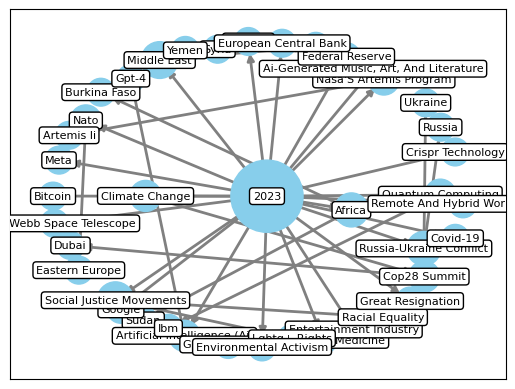

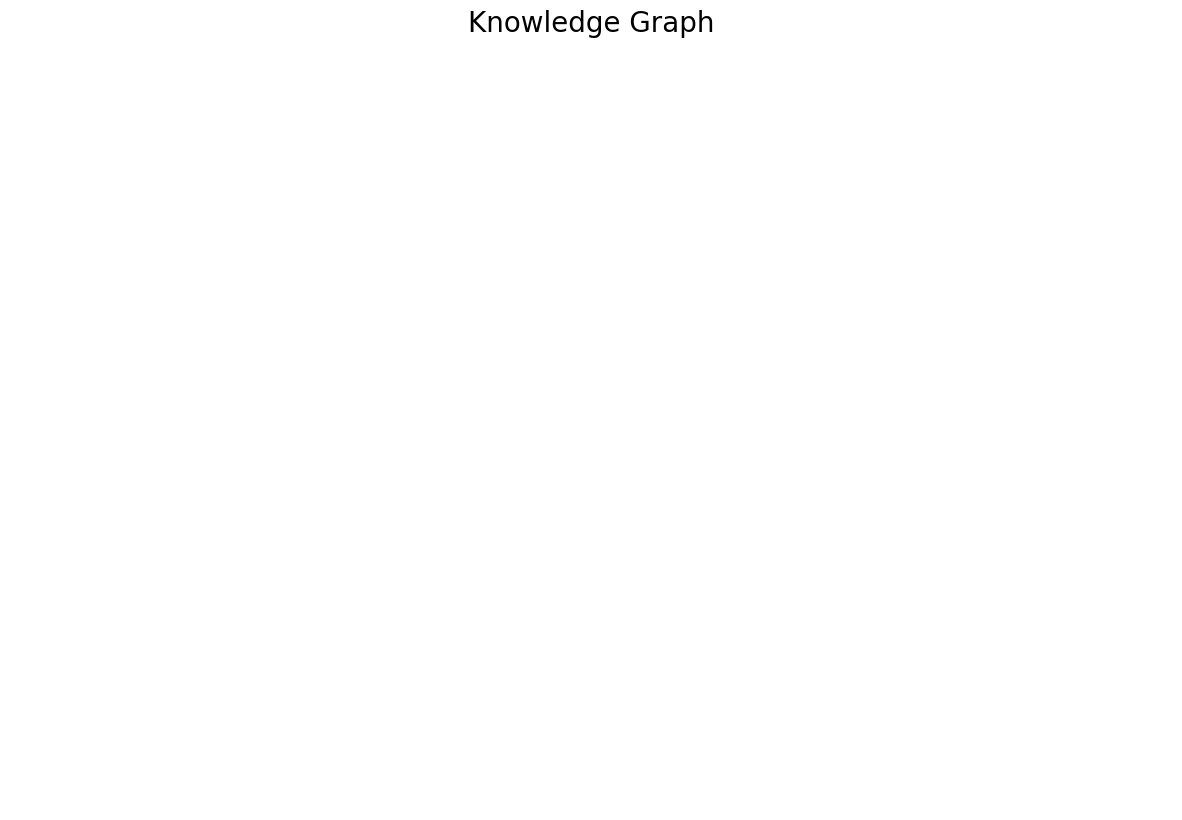

In [15]:
import matplotlib.pyplot as plt

def visualize_graph(graph_documents):
    G = nx.DiGraph()

    # Add nodes and edges to the graph
    for doc in graph_documents:
        for node in doc.nodes:
            if node.id:  # Use only the id for labels
                G.add_node(str(node.id), label=node.id)

        for relationship in doc.relationships:
            if relationship.source and relationship.target:  # Ensure relationships are valid
                G.add_edge(str(relationship.source.id), str(relationship.target.id), label=relationship.type)

    # Identify all nodes that are sources of relationships
    source_nodes = set(relationship.source.id for doc in graph_documents for relationship in doc.relationships)

    # Get positions for the nodes
    pos = nx.spring_layout(G, k=5, iterations=200, center=(0.5, 0.5))  # Increase k value for more spacing

    # Nodes with sizes based on their degree, reduced size
    node_sizes = [300 + 100 * G.degree(node) for node in G.nodes]
    nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color='skyblue')

    # Ensure every node has a label, defaulting to the node ID
    node_labels = {node: G.nodes[node].get('label', node) for node in G.nodes}

    # Node labels with increased font size and padding
    nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=8, font_family='sans-serif',
                            bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3'))

    # Edges
    nx.draw_networkx_edges(G, pos, edgelist=G.edges(), width=2, edge_color='gray')

    # Edge labels with increased font size
    #edge_labels = nx.get_edge_attributes(G, 'label')
    #nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8, label_pos=0.5, font_color='black')

    plt.figure(figsize=(15, 10))  # Increase figure size
    plt.title("Knowledge Graph", fontsize=20)
    plt.axis('off')  # Hide axis
    plt.show()
visualize_graph(graph_documents)

# Transport Knowledge Graph to Pytorch Geometric Graph

In [16]:
# Custom Data class to include num_classes and num_features
from torch_geometric.data import Data
class CustomData(Data):
    def __init__(self, num_classes=None, num_features=None, **kwargs):
        super().__init__(**kwargs)
        self.num_classes = num_classes
        self.num_features = num_features

    @classmethod
    def from_data(cls, data, num_classes=None, num_features=None):
        obj = cls(num_classes=num_classes, num_features=num_features, **data.to_dict())
        return obj

In [17]:
import torch
from community import community_louvain
def convert_to_pyg_data(graph_documents, num_features, num_classes):
    nodes = []
    edges = []

    # Extract nodes and edges from the graph documents
    node_id_map = {}
    for doc in graph_documents:
        for idx, node in enumerate(doc.nodes):
            if node.id not in node_id_map:
                node_id_map[node.id] = len(node_id_map)
                nodes.append(node.id)
        for relationship in doc.relationships:
            source_id = node_id_map[relationship.source.id]
            target_id = node_id_map[relationship.target.id]
            edges.append((source_id, target_id))

    # Convert nodes and edges to PyTorch tensors
    num_nodes = len(node_id_map)
    x = torch.eye(num_nodes, num_features)  # Identity matrix as dummy node features
    y = torch.randint(0, num_classes, (num_nodes,), dtype=torch.long)  # Random labels for demonstration

    return CustomData(x=x, edge_index=torch.tensor(edges, dtype=torch.long).t().contiguous(), y=y,
                      num_classes=num_classes, num_features=num_features)

def get_graph_stats(graph_documents):
    G = nx.Graph()

    # Extract nodes and edges from the graph documents to create a networkx graph
    for doc in graph_documents:
        for node in doc.nodes:
            G.add_node(node.id)
        for relationship in doc.relationships:
            G.add_edge(relationship.source.id, relationship.target.id)

    num_features = G.number_of_nodes()

    # Use community detection to find the number of clusters
    partition = community_louvain.best_partition(G)
    num_classes = len(set(partition.values()))

    return num_classes, num_features

# Display Graph

Number of classes: 10
Number of features: 41


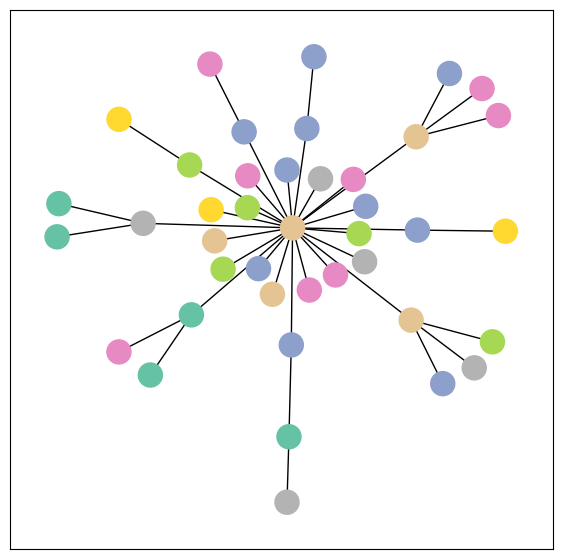

In [18]:
from torch_geometric.utils import to_networkx
def visualize_graph(G, color):
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])
    nx.draw_networkx(G, pos=nx.spring_layout(G, seed=42), with_labels=False,
                     node_color=color, cmap="Set2")
    plt.show()
num_classes, num_features = get_graph_stats(graph_documents)
print(f'Number of classes: {num_classes}')
print(f'Number of features: {num_features}')
data = convert_to_pyg_data(graph_documents,num_features,num_classes)
G = to_networkx(data, to_undirected=True)
visualize_graph(G, color=data.y)

# Setup Graph Neural Network

In [19]:
import torch.nn.functional as F
from torch.nn import Linear, Dropout
from torch_geometric.nn import GCNConv, GATv2Conv


class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        torch.manual_seed(1234)
        self.conv1 = GCNConv(data.num_features, 4)
        self.conv2 = GCNConv(4, 4)
        self.conv3 = GCNConv(4, 2)
        self.classifier = Linear(2, data.num_classes)

    def forward(self, x, edge_index):
        h = self.conv1(x, edge_index)
        h = h.tanh()
        h = self.conv2(h, edge_index)
        h = h.tanh()
        h = self.conv3(h, edge_index)
        h = h.tanh()  # Final GNN embedding space.

        # Apply a final (linear) classifier.
        out = self.classifier(h)

        return out, h


Embedding shape: [41, 2]


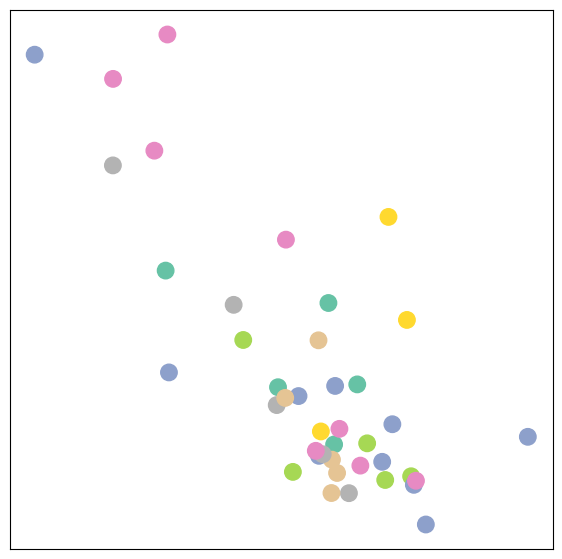

In [20]:
def visualize_embedding(h, color, epoch=None, loss=None):
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])
    h = h.detach().cpu().numpy()
    plt.scatter(h[:, 0], h[:, 1], s=140, c=color, cmap="Set2")
    if epoch is not None and loss is not None:
        plt.xlabel(f'Epoch: {epoch}, Loss: {loss.item():.4f}', fontsize=16)
    plt.show()
model = GCN()

_, h = model(data.x, data.edge_index)
print(f'Embedding shape: {list(h.shape)}')

visualize_embedding(h, color=data.y)

In [21]:
import time
from IPython.display import Javascript  # Restrict height of output cell.
# Define accuracy calculation function
def accuracy(pred_y, y):
    return (pred_y == y).sum().item() / y.size(0)

# Setup
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 430})'''))

model = GCN()
criterion = torch.nn.CrossEntropyLoss()  # Define loss criterion.
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)  # Define optimizer.

def train(data):
    optimizer.zero_grad()  # Clear gradients.
    out, h = model(data.x, data.edge_index)  # Perform a single forward pass.
    loss = criterion(out, data.y)  # Compute the loss based on all nodes.
    loss.backward()  # Derive gradients.
    optimizer.step()  # Update parameters based on gradients.
    return loss, h, out

<IPython.core.display.Javascript object>

# Train Graph Neural Network

Epoch: 0, Loss: 2.3090, Accuracy: 0.1220


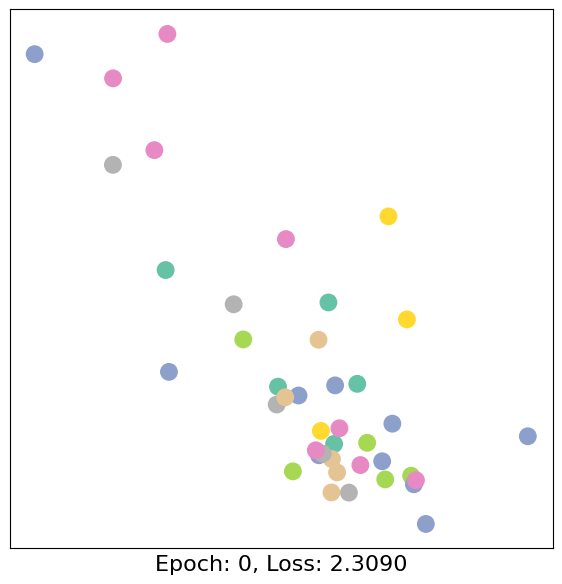

Epoch: 10, Loss: 2.1753, Accuracy: 0.2439


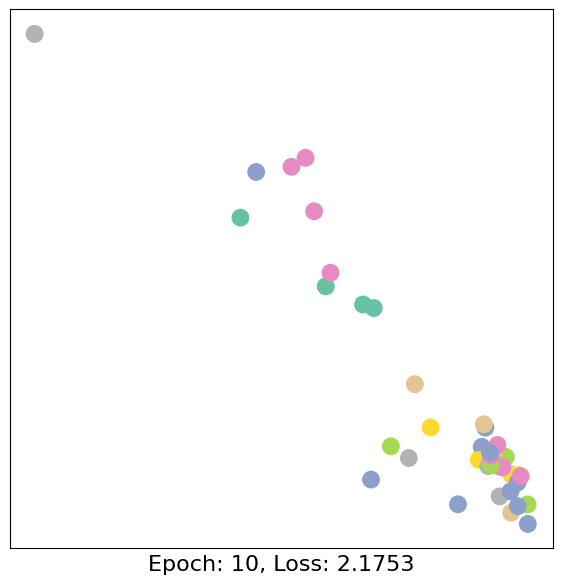

Epoch: 20, Loss: 2.0593, Accuracy: 0.1951


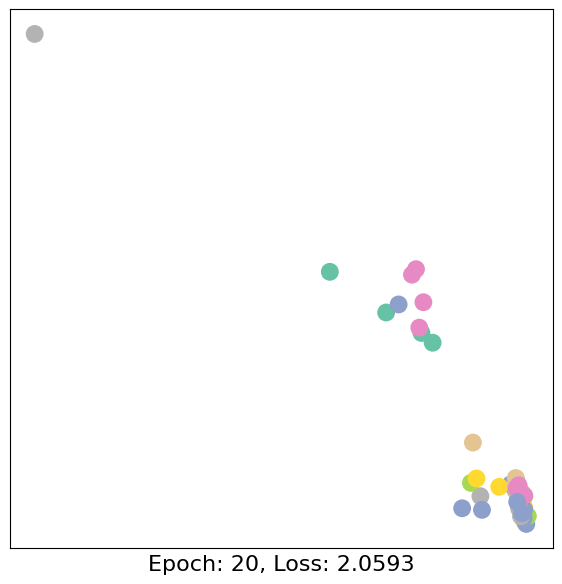

Epoch: 30, Loss: 1.9503, Accuracy: 0.3171


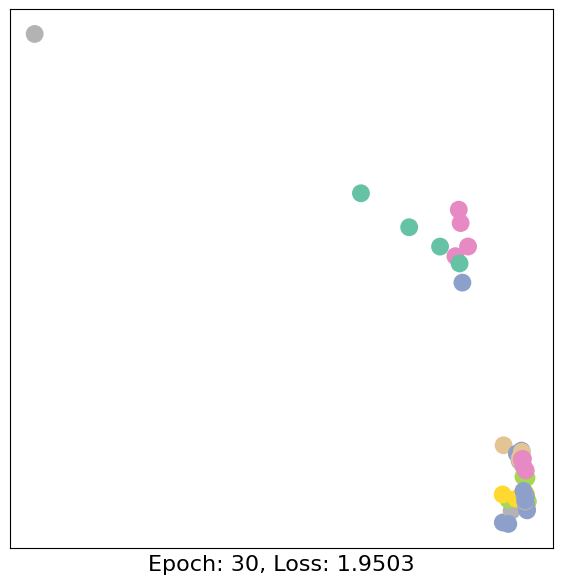

Epoch: 40, Loss: 1.8417, Accuracy: 0.3415


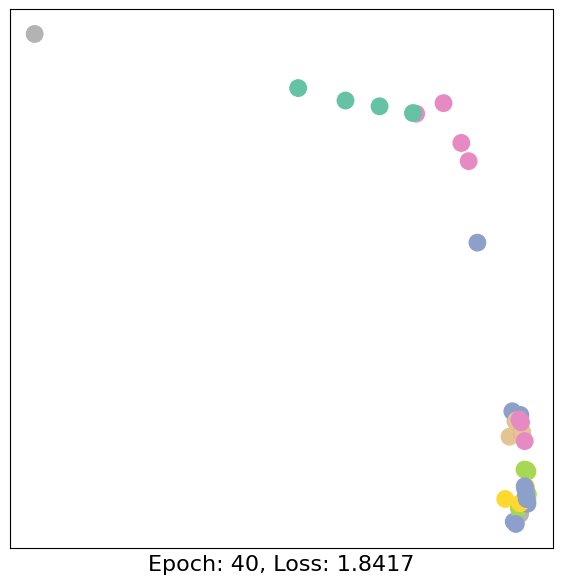

Epoch: 50, Loss: 1.7399, Accuracy: 0.3902


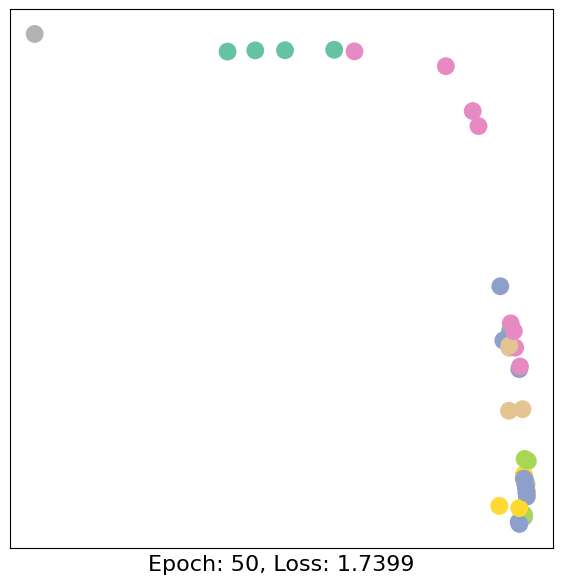

Epoch: 60, Loss: 1.6250, Accuracy: 0.4390


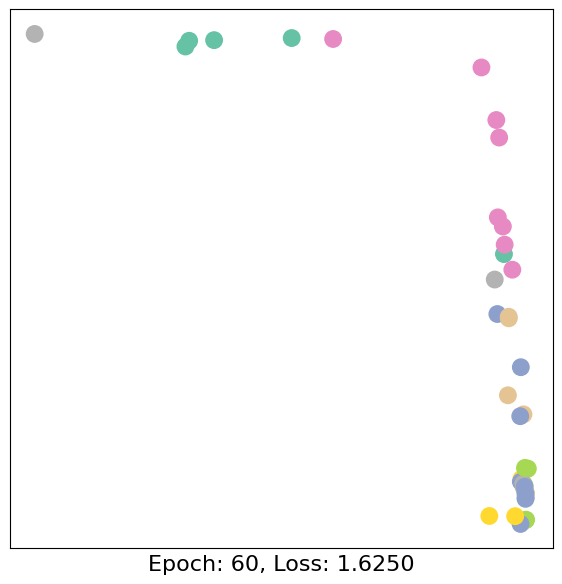

Epoch: 70, Loss: 1.5164, Accuracy: 0.4878


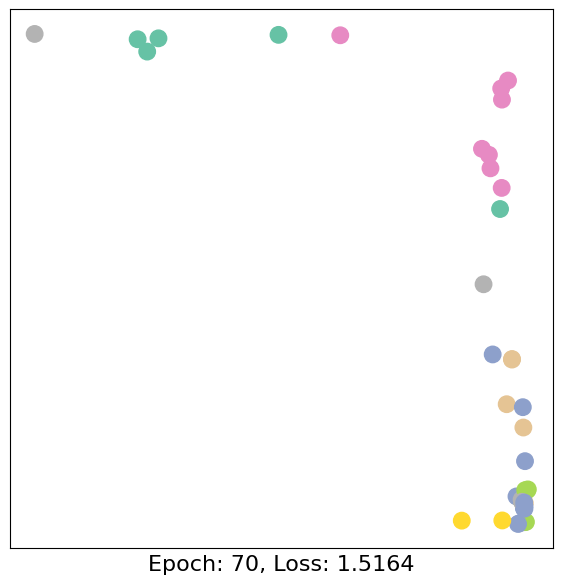

Epoch: 80, Loss: 1.4250, Accuracy: 0.4878


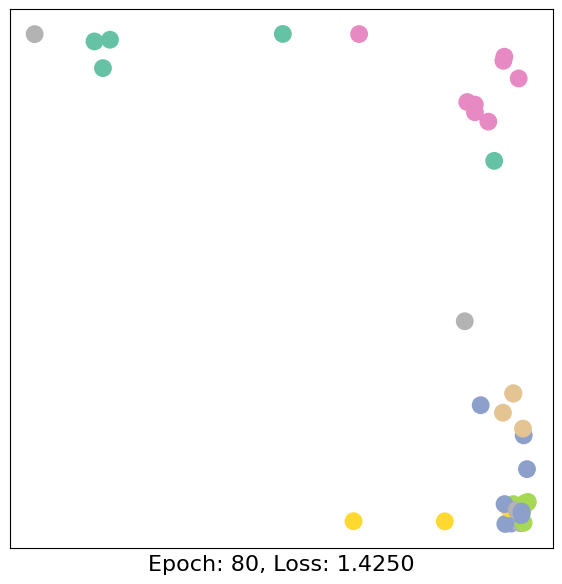

Epoch: 90, Loss: 1.3363, Accuracy: 0.4878


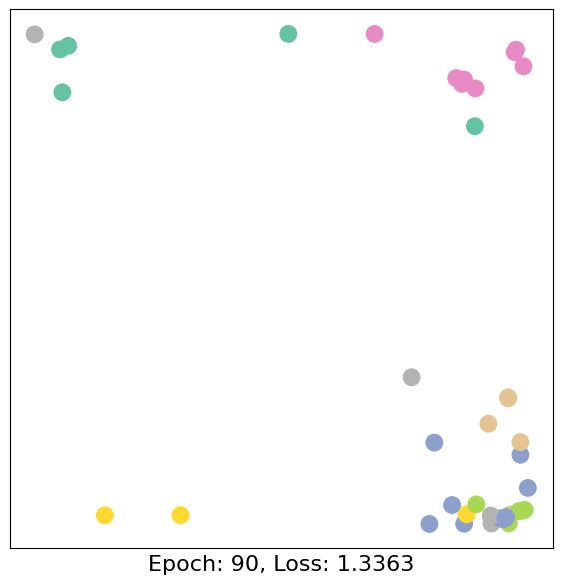

Epoch: 100, Loss: 1.2592, Accuracy: 0.4878


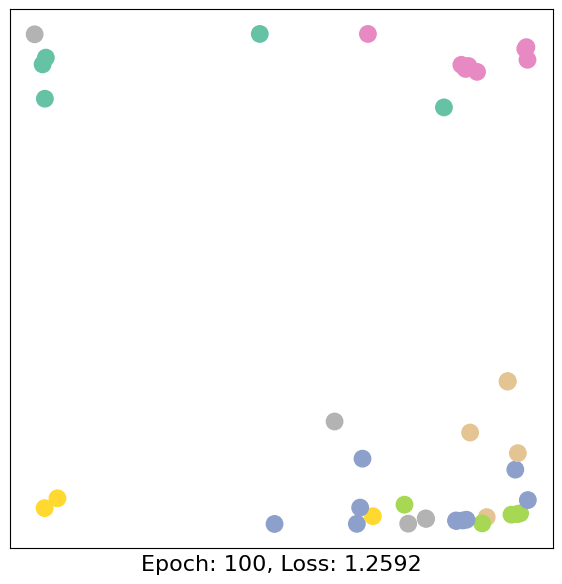

Epoch: 110, Loss: 1.1830, Accuracy: 0.6098


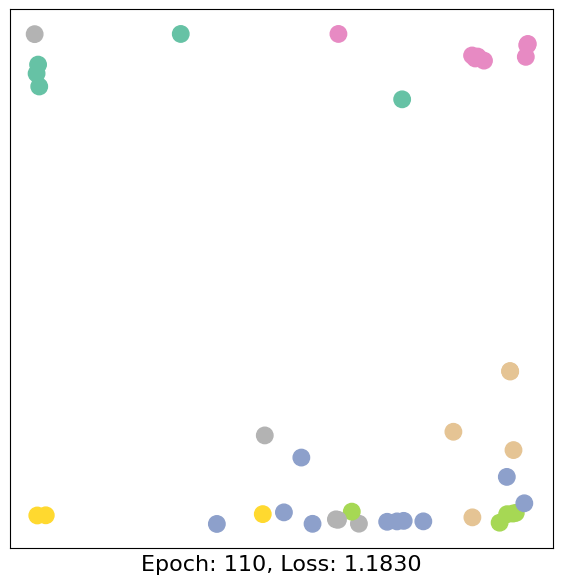

Epoch: 120, Loss: 1.1132, Accuracy: 0.6341


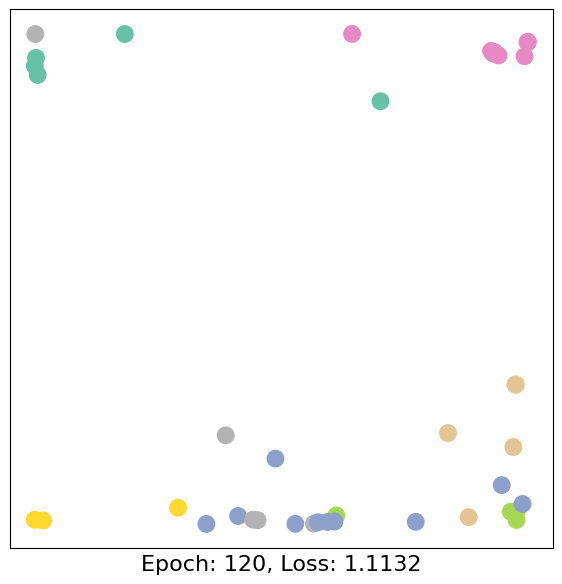

Epoch: 130, Loss: 1.0536, Accuracy: 0.6341


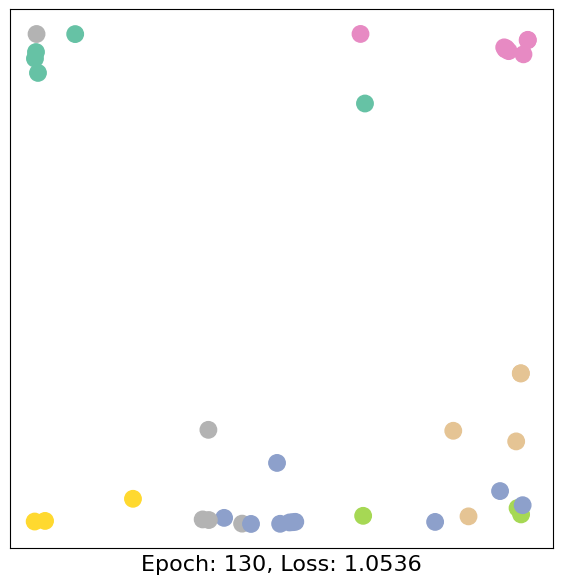

Epoch: 140, Loss: 1.0013, Accuracy: 0.6585


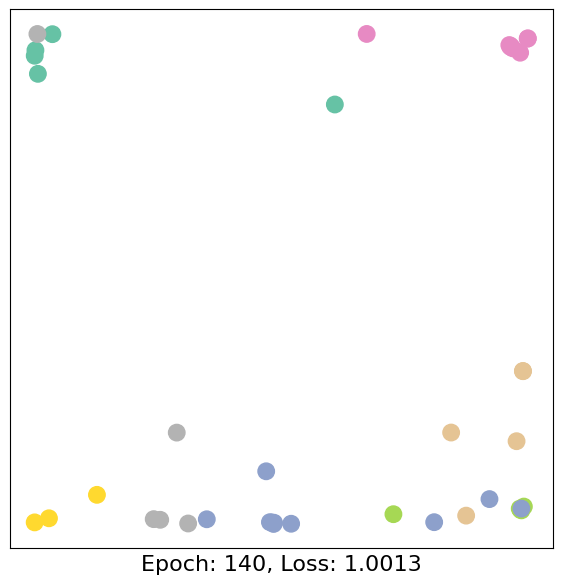

Epoch: 150, Loss: 0.9540, Accuracy: 0.7317


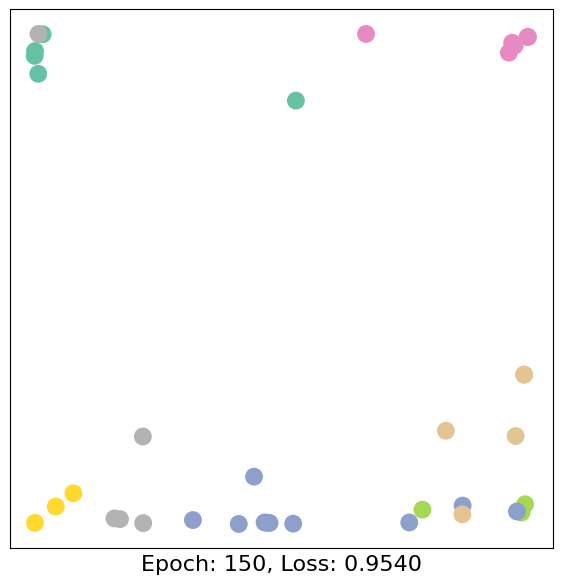

Epoch: 160, Loss: 0.9086, Accuracy: 0.7805


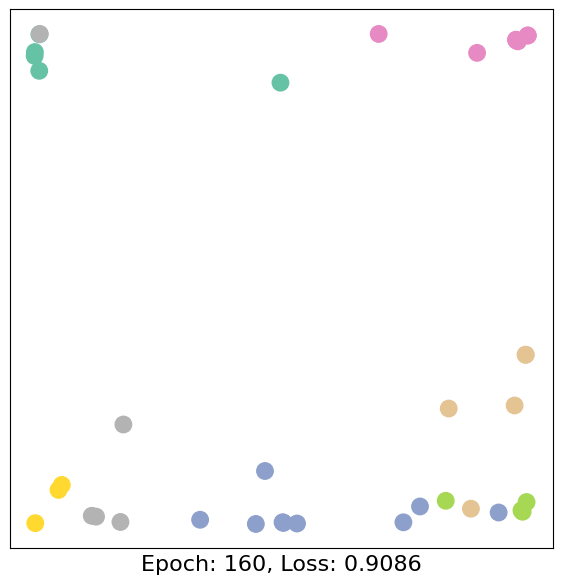

Epoch: 170, Loss: 0.8608, Accuracy: 0.7805


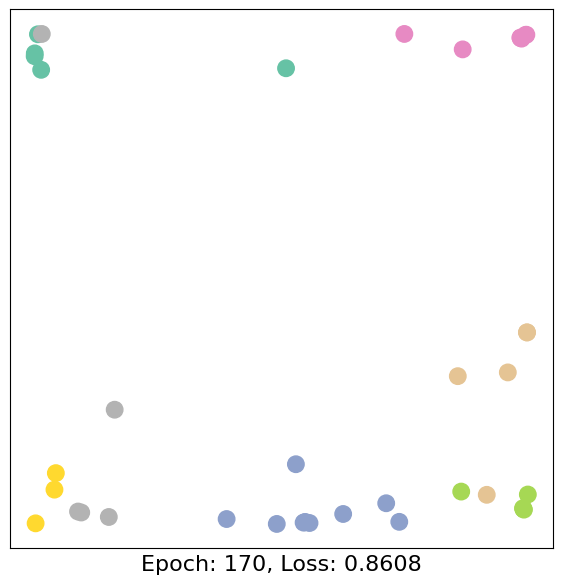

Epoch: 180, Loss: 0.8212, Accuracy: 0.8293


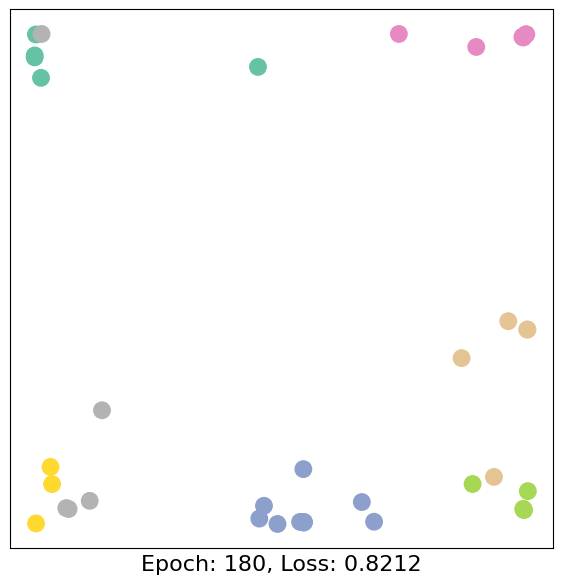

Epoch: 190, Loss: 0.7842, Accuracy: 0.8537


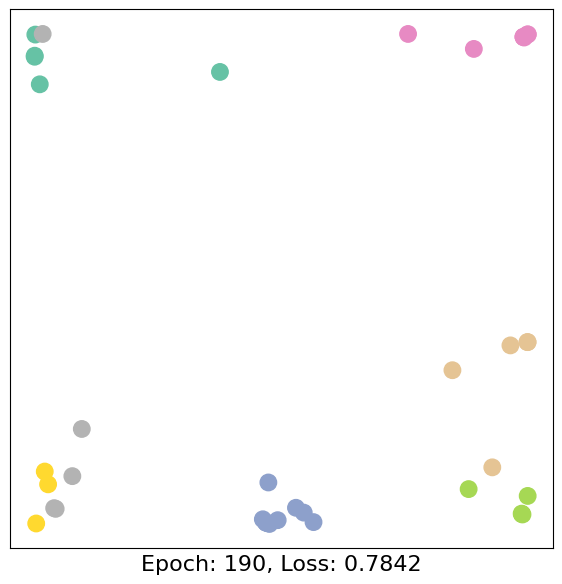

Epoch: 200, Loss: 0.7508, Accuracy: 0.8780


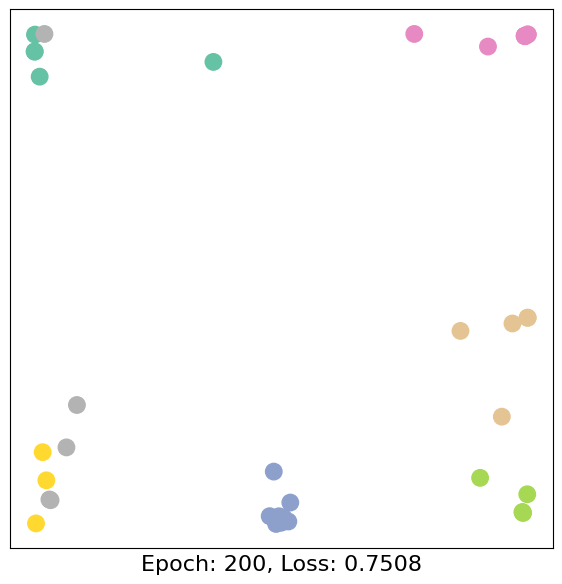

Epoch: 210, Loss: 0.7224, Accuracy: 0.8780


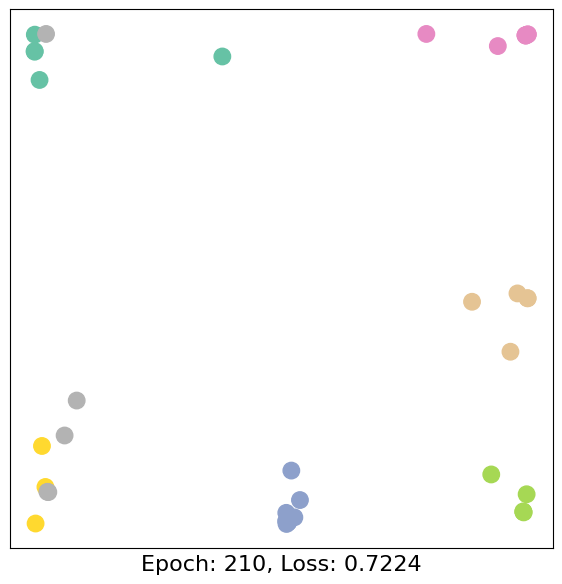

Epoch: 220, Loss: 0.6967, Accuracy: 0.8780


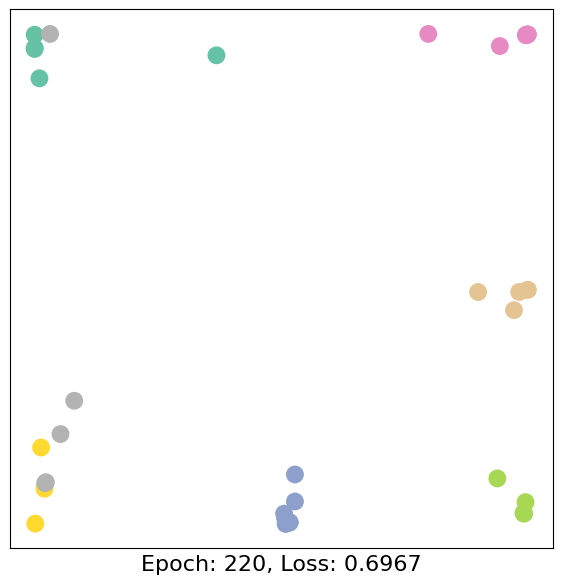

Epoch: 230, Loss: 0.6731, Accuracy: 0.8780


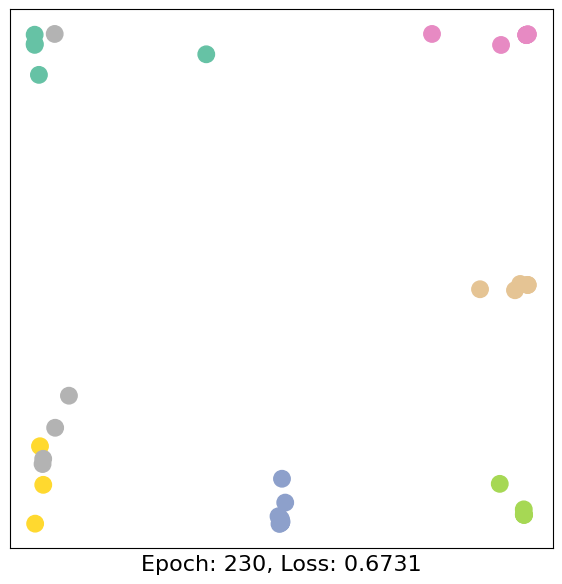

Epoch: 240, Loss: 0.6515, Accuracy: 0.8780


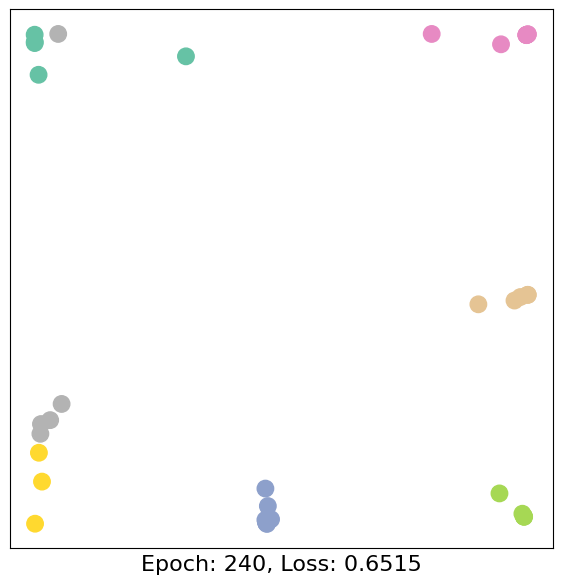

Epoch: 250, Loss: 0.6359, Accuracy: 0.8780


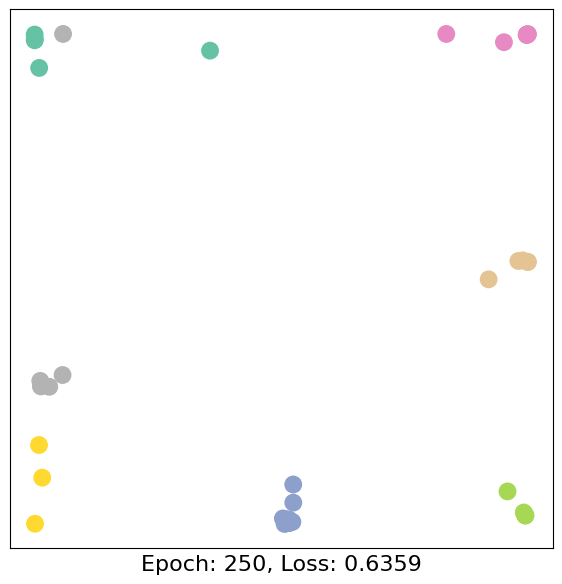

Epoch: 260, Loss: 0.6142, Accuracy: 0.9268


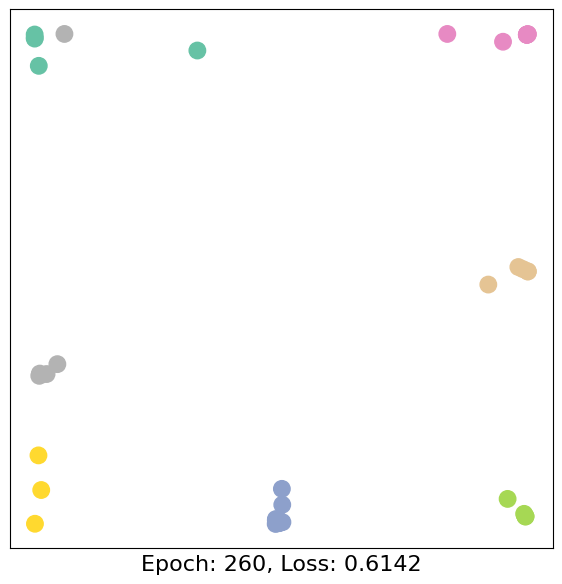

Epoch: 270, Loss: 0.5942, Accuracy: 0.9512


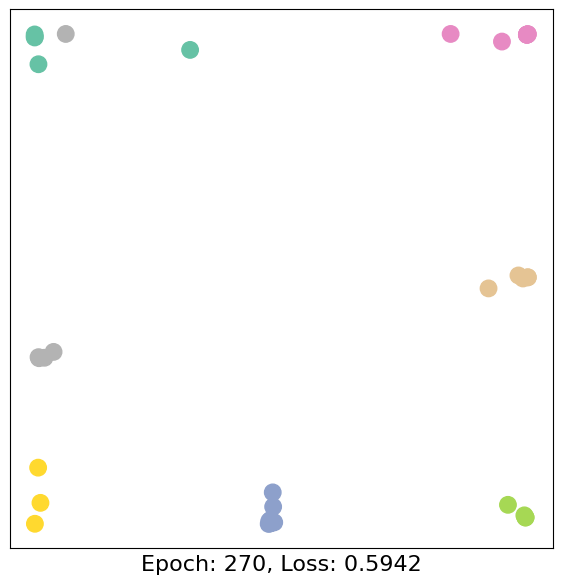

Epoch: 280, Loss: 0.5760, Accuracy: 0.9512


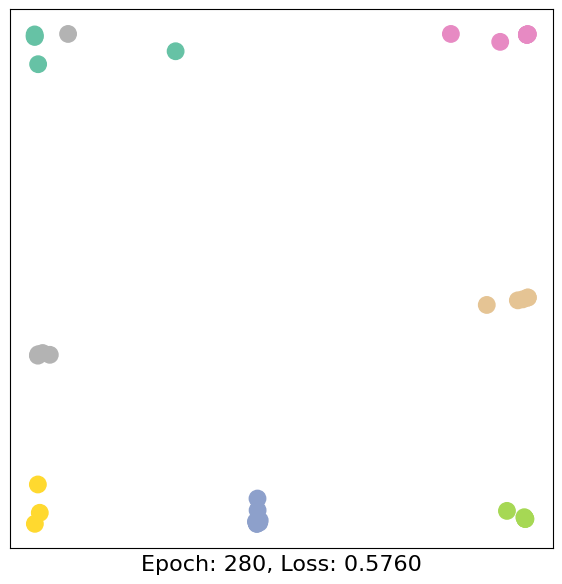

Epoch: 290, Loss: 0.5567, Accuracy: 0.9512


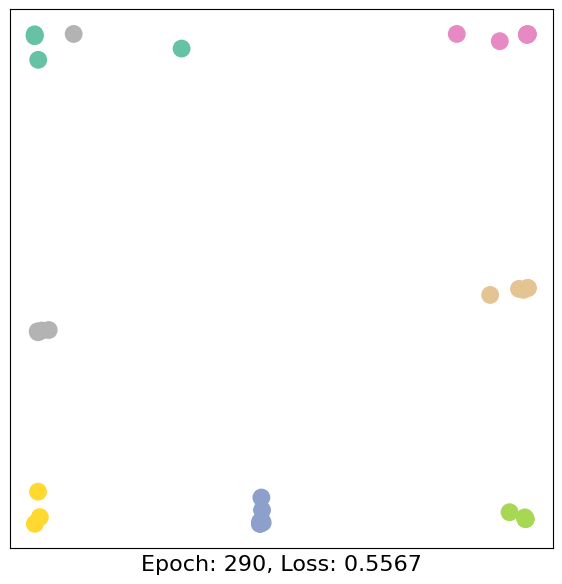

Epoch: 300, Loss: 0.5448, Accuracy: 0.9512


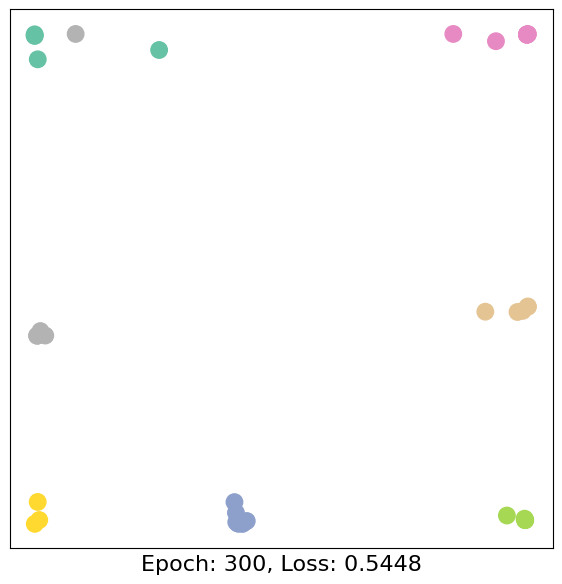

Epoch: 310, Loss: 0.5234, Accuracy: 0.9512


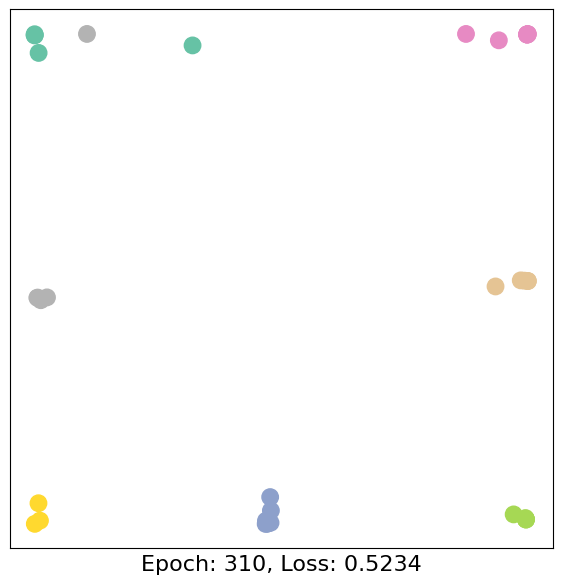

Epoch: 320, Loss: 0.5095, Accuracy: 0.9512


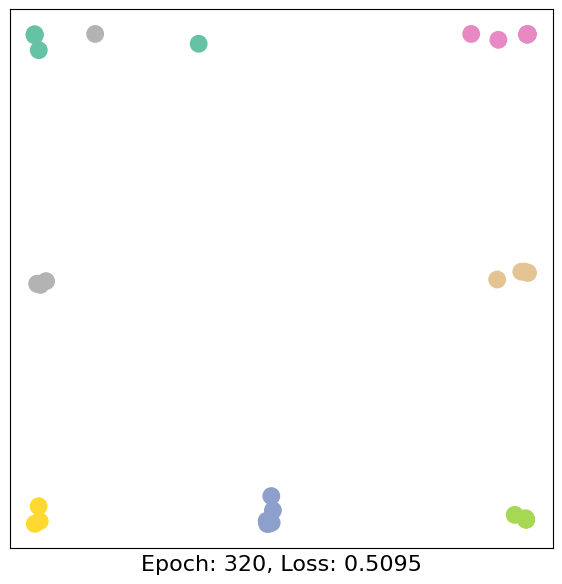

Epoch: 330, Loss: 0.4954, Accuracy: 0.9512


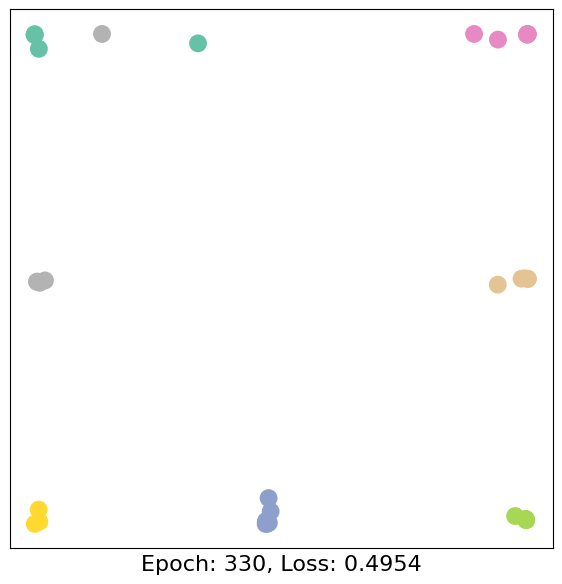

Epoch: 340, Loss: 0.4829, Accuracy: 0.9512


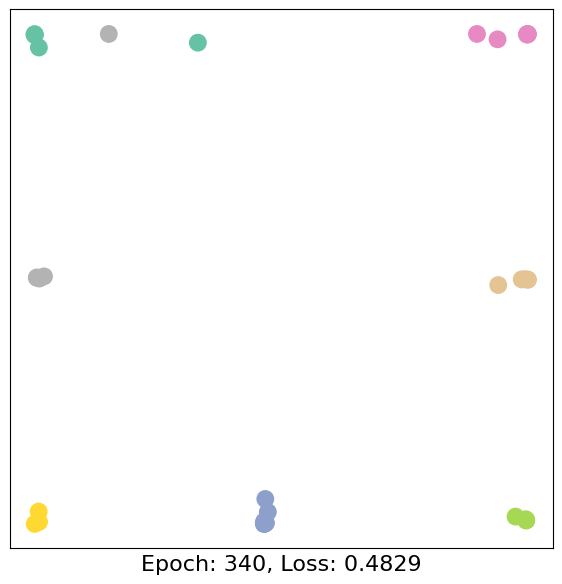

Epoch: 350, Loss: 0.4715, Accuracy: 0.9512


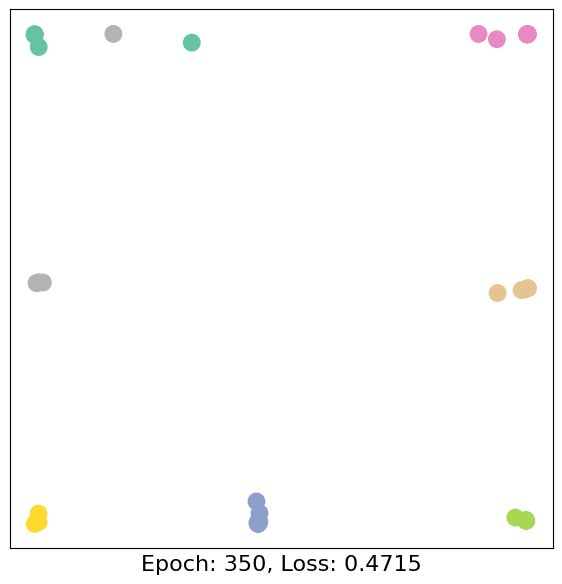

Epoch: 360, Loss: 0.4639, Accuracy: 0.9512


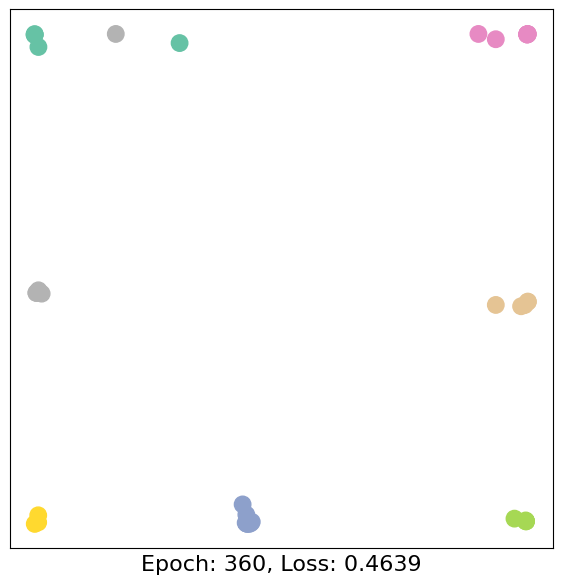

Epoch: 370, Loss: 0.4523, Accuracy: 0.9512


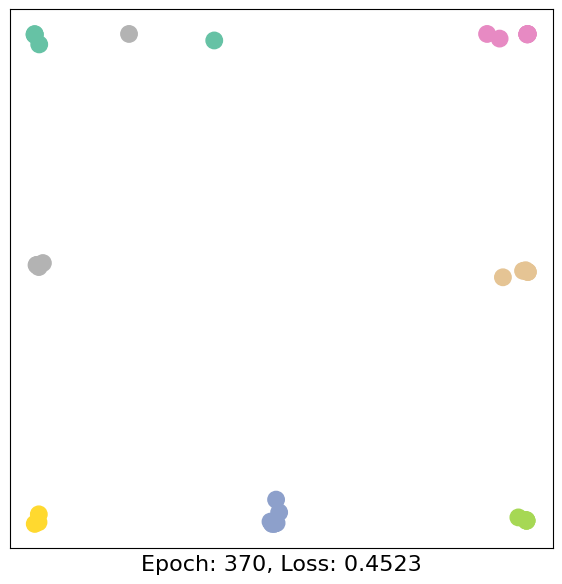

Epoch: 380, Loss: 0.4419, Accuracy: 0.9512


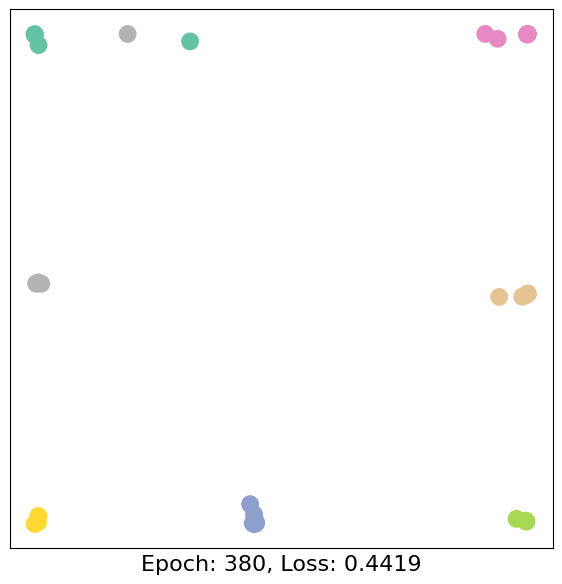

Epoch: 390, Loss: 0.4320, Accuracy: 0.9512


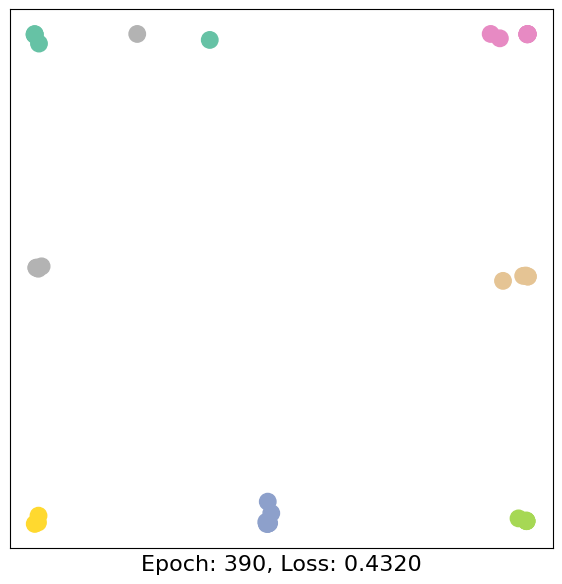

Epoch: 400, Loss: 0.4234, Accuracy: 0.9512


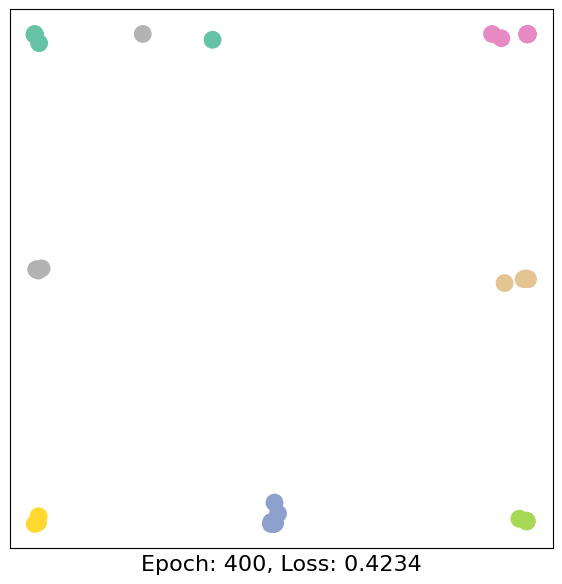

Final Accuracy: 0.9512


In [22]:
# Training loop
# Training loop
for epoch in range(401):
    loss, h, out = train(data)
    if epoch % 10 == 0:
        pred = out.argmax(dim=1)
        acc = accuracy(pred, data.y)
        print(f'Epoch: {epoch}, Loss: {loss:.4f}, Accuracy: {acc:.4f}')
        visualize_embedding(h, color=data.y, epoch=epoch, loss=loss)
        time.sleep(0.3)

# Compute final accuracy
pred = out.argmax(dim=1)
acc = accuracy(pred, data.y)
print(f'Final Accuracy: {acc:.4f}')

# Display Clusters

In [23]:
# Group and print node values by clusters
clusters = {}
for idx, cluster in enumerate(pred.tolist()):
    if cluster not in clusters:
        clusters[cluster] = []
    clusters[cluster].append(idx)

for cluster, nodes in clusters.items():
    print(f'Cluster {cluster}:')
    for node in nodes:
        node_id = graph_documents[0].nodes[node].id  # Get the node ID
        node_value = h[node].detach().cpu().numpy()
        print(f'  Node {node_id}: {node_value}')

Cluster 7:
  Node 2023: [ 0.9055707  -0.01686395]
  Node Middle East: [ 9.8268795e-01 -9.2256046e-04]
  Node Meta: [ 9.9985617e-01 -8.4447843e-04]
  Node Entertainment Industry: [ 9.9984521e-01 -7.6514465e-04]
  Node Social Justice Movements: [0.99201995 0.00204771]
Cluster 8:
  Node Russia-Ukraine Conflict: [-0.97206014  0.04308755]
  Node Yemen: [-0.9854864   0.03416918]
  Node Crispr Technology: [-0.99336624  0.03891076]
  Node Environmental Activism: [-0.99253803  0.03885392]
Cluster 0:
  Node Russia: [-0.99990594  0.997789  ]
  Node Ukraine: [-0.9999383   0.99691194]
  Node Burkina Faso: [-0.9998914  0.9996099]
  Node Cop28 Summit: [-0.9819154  0.9625378]
Cluster 3:
  Node Nato: [-0.01331462 -0.9576253 ]
  Node Syria: [-0.03866511 -0.9968434 ]
  Node Climate Change: [-0.02740028 -0.91298133]
  Node Artificial Intelligence (Ai): [-0.0251047  -0.99688476]
  Node Gpt-4: [-0.04178524 -0.9999801 ]
  Node Nasa'S Artemis Program: [-0.02695215 -0.995637  ]
  Node Ai-Generated Music, Art, 

# Remove Clusters that only have 2 nodes

In this example, Cluster 1 including "Africa" and "Dubai" are removed.

These 2 nodes are in the entirety of the knowledge graph not important details.

In [25]:
# Remove clusters with only one node
clusters = {cluster: nodes for cluster, nodes in clusters.items() if len(nodes) > 2}

# Print the remaining clusters and nodes
for cluster, nodes in clusters.items():
    print(f'Cluster {cluster}:')
    for node in nodes:
        node_id = graph_documents[0].nodes[node].id  # Get the node ID
        node_value = h[node].detach().cpu().numpy()
        print(f'  Node {node_id}: {node_value}')

Cluster 7:
  Node 2023: [ 0.9055707  -0.01686395]
  Node Middle East: [ 9.8268795e-01 -9.2256046e-04]
  Node Meta: [ 9.9985617e-01 -8.4447843e-04]
  Node Entertainment Industry: [ 9.9984521e-01 -7.6514465e-04]
  Node Social Justice Movements: [0.99201995 0.00204771]
Cluster 8:
  Node Russia-Ukraine Conflict: [-0.97206014  0.04308755]
  Node Yemen: [-0.9854864   0.03416918]
  Node Crispr Technology: [-0.99336624  0.03891076]
  Node Environmental Activism: [-0.99253803  0.03885392]
Cluster 0:
  Node Russia: [-0.99990594  0.997789  ]
  Node Ukraine: [-0.9999383   0.99691194]
  Node Burkina Faso: [-0.9998914  0.9996099]
  Node Cop28 Summit: [-0.9819154  0.9625378]
Cluster 3:
  Node Nato: [-0.01331462 -0.9576253 ]
  Node Syria: [-0.03866511 -0.9968434 ]
  Node Climate Change: [-0.02740028 -0.91298133]
  Node Artificial Intelligence (Ai): [-0.0251047  -0.99688476]
  Node Gpt-4: [-0.04178524 -0.9999801 ]
  Node Nasa'S Artemis Program: [-0.02695215 -0.995637  ]
  Node Ai-Generated Music, Art, 